<a href="https://colab.research.google.com/github/elder-storck/Disciplina-Redes-Neurais/blob/main/T1-diferencia%C3%A7%C3%A3o-autom%C3%A1tica-com-grafos-computacionais/casos_de_teste_complexos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testes mais Complicadinhos do Código do Trabalho


As demais células usam o sistema desenvolvido no trabalho para resolver vários problemas. Para utilizá-las, você pode:

1. Colar na célula abaixo todas as classes do notebook de especificação e as definições das operações ou
2. Copiar as células com os problemas para o final do notebook de especificação. **Esta opção parece menos trabalhosa**.

No VSCode, você pode selecionar várias células usando shift e clicando na área à esquerda das células. Em seguida, você pode copiar usando ctrl+c (ou ctrl+x para recortar) e colar usando ctrl+v. Realize a operação com cautela para evitar perder os códigos já feitos para o trabalho.

Ao executar as células dos problemas, deverão ser exibidos valores cada vez menores da loss e uma visualização do resultado.

**IMPORTANTE:** Este notebook **NÃO** deve ser enviado como resposta no testr. Apenas o notebook de especificação deve ser enviado.

## Casos de Teste

In [ ]:
from typing import Optional, Union, Any
from collections.abc import Iterable
from abc import ABC, abstractmethod
import numbers

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [ ]:

class NameManager:
    _counts = {}

    @staticmethod
    def reset():
        NameManager._counts = {}

    @staticmethod
    def _count(name):
        if name not in NameManager._counts:
            NameManager._counts[name] = 0
        count = NameManager._counts[name]
        return count

    @staticmethod
    def _inc_count(name):
        assert name in NameManager._counts, f'Name {name} is not registered.'
        NameManager._counts[name] += 1

    @staticmethod
    def new(name: str):
        count = NameManager._count(name)
        tensor_name = f"{name}:{count}"
        NameManager._inc_count(name)
        return tensor_name

# exemplo de uso
print(NameManager.new('add'))
print(NameManager.new('in'))
print(NameManager.new('add'))
print(NameManager.new('add'))
print(NameManager.new('in'))
print(NameManager.new('prod'))

NameManager.reset()

add:0
in:0
add:1
add:2
in:1
prod:0


In [ ]:

class Tensor:
    """Classe representando um array multidimensional.

    Atributos:

    - _arr  (privado): dados internos do tensor como
        um array do numpy com 2 dimensões (ver Regras)

    - _parents (privado): lista de tensores que foram
        usados como argumento para a operação que gerou o
        tensor. Será vazia se o tensor foi inicializado com
        valores diretamente. Por exemplo, se o tensor foi
        resultado da operação a + b entre os tensores a e b,
        _parents = [a, b].

    - requires_grad (público): indica se devem ser
        calculados gradientes para o tensor ou não.

    - grad (público): Tensor representando o gradiente.

    """

    def __init__(self,
                 # Dados do tensor. Além dos tipos listados,
                 # arr também pode ser do tipo Tensor.
                 arr: Union[np.ndarray, list, numbers.Number, Any],
                 # Entradas da operacao que gerou o tensor.
                 # Deve ser uma lista de itens do tipo Tensor.
                 parents: list[Any] = [],
                 # se o tensor requer o calculo de gradientes ou nao
                 requires_grad: bool = True,
                 # nome do tensor
                 name: str = '',
                 # referência para um objeto do tipo Operation (ou
                 # subclasse) indicando qual operação gerou este
                 # tensor. Este objeto também possui um método
                 # para calcular a derivada da operação.
                 operation=None):
        """Construtor

        O construtor deve permitir a criacao de tensores das seguintes formas:

            # a partir de escalares
            x = Tensor(3)

            # a partir de listas
            x = Tensor([1,2,3])

            # a partir de arrays
            x = Tensor(np.array([1,2,3]))

            # a partir de outros tensores (construtor de copia)
            x = Tensor(Tensor(np.array([1,2,3])))

        Para isto, as seguintes regras devem ser obedecidas:

        - Se o argumento arr não for um array do numpy,
            ele deve ser convertido em um. Defina o dtype do
            array como float de forma a permitir que NÃO seja
            necessário passar constantes float como Tensor(3.0),
            mas possamos criar um tensor apenas com Tensor(3).

        - O atributo _arr deve ser uma matriz, isto é,
            ter 2 dimensões (ver Regras).

        - Se o argumento arr for um Tensor, ele deve ser
            copiado (cuidado com cópias por referência).

        - Se arr for um array do numpy com 1 dimensão,
            ele deve ser convertido em uma matriz coluna.

        - Se arr for um array do numpy com dimensão maior
            que 2, deve ser lançada uma exceção.

        - Tensores que não foram produzidos como resultado
            de uma operação não têm pais nem operação.
            Os nomes destes tensores devem seguir o formato in:3.
        """

       # Se arr for Tensor → cópia (construtor de cópia)
        if isinstance(arr, Tensor):
            self._arr = arr._arr.copy()

        else:
            # Converte para numpy array float
            if not isinstance(arr, np.ndarray):
                arr = np.array(arr, dtype=float)
            else:
                arr = arr.astype(float)

            # Escalar → matriz 1x1
            if arr.ndim == 0:
                arr = arr.reshape(1, 1)

            # Vetor → matriz coluna
            elif arr.ndim == 1:
                arr = arr.reshape(arr.shape[0], 1)

            # Mais de 2 dimensões → erro
            elif arr.ndim > 2:
                raise ValueError("Tensor deve ser sempre uma matriz (2D)")

            self._arr = arr


        # if operation is None:
        #   self._name = NameManager.new('in')
        # else:
        #   self._name = NameManager.new(operation.name)

        #metadados do tensor
        self._parents = parents
        self.requires_grad = requires_grad
        self.operation = operation
        self.grad = None

        # # -------- NOME --------
        if name != '':
            # print("name:"+name)
            self._name = name
        else:
            if not parents and operation is None:
                # print("name_in:")
                self._name = NameManager.new('in')
            else:
                self._name = NameManager.new(operation.name)


    def zero_grad(self):
        """Reinicia o gradiente com zero"""
        self.grad = Tensor(np.zeros_like(self._arr))

    def numpy(self):
        """Retorna o array interno"""
        return self._arr

    def __repr__(self):
        """Permite visualizar os dados do tensor como string"""
        return f"Tensor({self._arr}, name={self._name}, shape={self._arr.shape})"

    def backward(self, my_grad=None):
        """Método usado tanto iniciar o processo de
        diferenciação automática, quanto por um filho
        para enviar o gradiente do pai. No primeiro
        caso, o argumento my_grad não será passado.
        """
        #caso inicial
        if my_grad is None:
          my_grad = Tensor(np.ones_like(self._arr))
          # my_grad = np.ones_like(self._arr)

        # primeira chegada de grad
        if self.grad is None:
            if self.operation is None:
                # É tensor de entrada → in_grad
                self.grad = Tensor(my_grad.numpy(),name=NameManager.new("in_grad"),requires_grad=False)
            else:
                # É tensor intermediário → grad normal
                self.grad = Tensor(my_grad.numpy(),requires_grad=False)
        else:
            # acumula gradiente
            self.grad = Tensor(my_grad.numpy() + self.grad.numpy(),requires_grad=False)


        # Verificando se é tensor de entrada
        if self.operation is None:
          return

        # Calcula gradientes locais via operação
        grads = self.operation.grad(self.grad, *self._parents)

        # Propaga para os pais
        for parent, g in zip(self._parents, grads):
            if parent.requires_grad:
                parent.backward(g)


In [ ]:

class Op(ABC):
    name: str = ''
    @abstractmethod
    def __call__(self, *args, **kwargs) -> Tensor:
        """Realiza a operação usando as entradas e
            retorna o tensor resultado. O método deve
            garantir que o atributo parents do tensor
            de saída seja uma lista de tensores."""

    @abstractmethod
    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        """Retorna os gradientes dos pais em como tensores.

        Arguments:

        - back_grad: Derivada parcial em relação à saída
            da operação backpropagada pelo filho.

        - args: variaveis de entrada da operacao (pais)
            como tensores.

        - O nome dos tensores de gradiente devem ter o
            nome da operacao seguido de '_grad'.
        """

    def _ts(self, *args) -> list[Tensor]:
        vals = []
        for a in args:
            if isinstance(a, Tensor):
                vals.append(a)
            else:
                vals.append(Tensor(a, requires_grad=False))
        return vals



In [ ]:
class Add(Op):
    """Add(a, b): a + b"""
    name = "add"
    def __call__(self, *args, **kwargs) -> Tensor:
        """Realiza a operação usando os argumentos dados em args"""
        args = self._ts(*args)
        result = args[0].numpy() + args[1].numpy()
        return Tensor(result, parents=args, name=NameManager.new('add'), operation=self)

    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        return [Tensor(back_grad.numpy(), name=NameManager.new('add_grad')),
                Tensor(back_grad.numpy(), name=NameManager.new('add_grad'))]

# Instancia a classe. O objeto passa a poder ser usado como uma funcao
add = Add()

In [ ]:

class Sub(Op):
    """Sub(a, b): a - b"""
    # name = "sub"
    def __call__(self, *args, **kwargs) -> Tensor:
        """Realiza a operação usando os argumentos dados em args"""
        args = self._ts(*args)
        result = args[0].numpy() - args[1].numpy()
        return Tensor(result, parents=args, name=NameManager.new('sub'), operation=self)

    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        """Retorna a lista de derivadas parciais em relação aos pais (passados em args)"""
        arg = self._ts(*args)
        return [Tensor(back_grad.numpy(), name=NameManager.new('sub_grad')),
                Tensor(-back_grad.numpy(), name=NameManager.new('sub_grad'))]

# Instancia a classe. O objeto passa a poder ser usado como uma funcao
sub = Sub()

In [ ]:

class Prod(Op):
    """Prod(a, b): produto ponto a ponto de a e b ou produto escalar-tensor"""
    def __call__(self, *args, **kwargs) -> Tensor:
        args = self._ts(*args)
        result = args[0].numpy() * args[1].numpy()
        return Tensor(result, parents=args, name=NameManager.new('prod'), operation=self)


    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        """Retorna a lista de derivadas parciais em relação aos pais (passados em args)"""
        arg = self._ts(*args)
        return [Tensor(arg[1].numpy()*back_grad.numpy(), name=NameManager.new('prod_grad')),
                Tensor(arg[0].numpy()*back_grad.numpy(), name=NameManager.new('prod_grad'))]

# Instancia a classe. O objeto passa a poder ser usado como uma funcao
prod = Prod()

In [ ]:

class Sin(Op):
    """seno element-wise"""
    def __call__(self, *args, **kwargs) -> Tensor:
        args = self._ts(*args)
        result = np.sin(args[0].numpy())
        return Tensor(result, parents=args, name=NameManager.new('sin'), operation=self)

    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        arg = self._ts(*args)
        return [Tensor(np.cos(arg[0].numpy())*back_grad.numpy(), name=NameManager.new('sin_grad'))]

# Instancia a classe. O objeto passa a poder ser usado como uma funcao
sin = Sin()

In [ ]:

class Cos(Op):
    """cosseno element-wise"""
    def __call__(self, *args, **kwargs) -> Tensor:
        args = self._ts(*args)
        result = np.cos(args[0].numpy())
        return Tensor(result, parents=args, name=NameManager.new('cos'), operation=self)

    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        args = self._ts(*args)
        return [Tensor((-np.sin(args[0].numpy()))*back_grad.numpy(), name=NameManager.new('cos_grad'))]


# Instancia a classe. O objeto passa a poder ser usado como uma funcao
cos = Cos()

In [ ]:

class Sum(Op):
    """Retorna a soma dos elementos do tensor"""
    def __call__(self, *args, **kwargs) -> Tensor:
        args = self._ts(*args)
        result = np.sum(args[0].numpy())
        return Tensor(result, parents=args, name=NameManager.new('sum'), operation=self)

    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        arg = self._ts(*args)
        return [Tensor(np.ones_like(arg[0].numpy())*back_grad.numpy(), name=NameManager.new('sum_grad'))]

# Instancia a classe. O objeto passa a poder ser usado como uma funcao
# ⚠️ vamos chamar de my_sum porque python ja possui uma funcao sum
my_sum = Sum()

In [ ]:

class Mean(Op):
    """Retorna a média dos elementos do tensor"""
    def __call__(self, *args, **kwargs) -> Tensor:
        args = self._ts(*args)
        result = np.average(args[0].numpy())
        return Tensor(result, parents=args, name=NameManager.new('mean'), operation=self)

    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        arg = self._ts(*args)

        x = arg[0].numpy()
        n = x.size  # número de elementos do tensor original
        grad_value = np.ones_like(x) * (back_grad.numpy() / n)

        return [Tensor((np.ones_like(arg[0].numpy())*back_grad.numpy())/arg[0].numpy().size, name=NameManager.new('avr_grad'))]

# Instancia a classe. O objeto passa a poder ser usado como uma funcao
mean = Mean()

In [ ]:

class Square(Op):
    """Eleva cada elemento ao quadrado"""
    def __call__(self, *args, **kwargs) -> Tensor:
        args = self._ts(*args)
        result = np.square(args[0].numpy())
        return Tensor(result, parents=args, name=NameManager.new('sqr'), operation=self)

    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        arg = self._ts(*args)
        return [Tensor(2*arg[0].numpy()*back_grad.numpy(), name=NameManager.new('sqr_grad'))]

# Instancia a classe. O objeto passa a poder ser usado como uma funcao
square = Square()

In [ ]:
# from numpy._core.defchararray import translate

class MatMul(Op):
    """MatMul(A, B): multiplicação de matrizes

    C = A @ B
    de/dA = de/dc @ B^T
    de/dB = A^T @ de/dc

    """

    def __call__(self, *args, **kwargs) -> Tensor:
        args1, args2 = self._ts(*args)
        result = args1.numpy() @ args2.numpy()
        return Tensor(result, parents=[args1,args2], name=NameManager.new('matMul'), operation=self)

    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        a, b = self._ts(*args)

        da = back_grad.numpy() @ b.numpy().T
        db = a.numpy().T @ back_grad.numpy()

        return [Tensor(da, name=NameManager.new('matMul_grad')),
                Tensor(db, name=NameManager.new('matMul_grad'))]

# Instancia a classe. O objeto passa a poder ser usado como uma funcao
matmul = MatMul()

In [ ]:

class Exp(Op):
    """Exponenciação element-wise"""
    def __call__(self, *args, **kwargs) -> Tensor:
        args = self._ts(*args)

        result = np.exp(args[0].numpy())
        return Tensor(result, parents=args, name=NameManager.new('exp'), operation=self)

    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        args = self._ts(*args)
        return [Tensor(np.exp(args[0].numpy())*back_grad.numpy(), name=NameManager.new('sqr_grad'))]

# Instancia a classe. O objeto passa a poder ser usado como uma funcao
exp = Exp()

In [ ]:

class ReLU(Op):
    """ReLU element-wise"""
    def __call__(self, *args, **kwargs) -> Tensor:
        args = self._ts(*args)
        result = np.maximum(0, args[0].numpy())

        return Tensor(result, parents=args, name=NameManager.new('relu'), operation=self)

    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        args = self._ts(*args)

        # Derivada da ReLU: 1 onde x>0, senão 0
        relu_derivative = (args[0].numpy() > 0).astype(float)

        return [Tensor(relu_derivative*back_grad.numpy(), name=NameManager.new('relu_grad'))]

# Instancia a classe. O objeto passa a poder ser usado como uma funcao
relu = ReLU()

In [ ]:

class Sigmoid(Op):
    """Sigmoid element-wise"""
    def __call__(self, *args, **kwargs) -> Tensor:
        args = self._ts(*args)
        result = 1.0 / ( 1.0 + np.exp(-args[0].numpy()))

        return Tensor(result, parents=args, name=NameManager.new('sigmoid'), operation=self)

    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        args = self._ts(*args)

        # 𝑠𝑖𝑔𝑚(𝑥) ∗ (1 − 𝑠𝑖𝑔𝑚(𝑥))
        sig_derivative = (1.0 / ( 1.0 + np.exp(-args[0].numpy()))) * (1.0 - (1.0 / ( 1.0 + np.exp(-args[0].numpy()))))

        return [Tensor(sig_derivative*back_grad.numpy(), name=NameManager.new('sig_grad'))]

# Instancia a classe. O objeto passa a poder ser usado como uma funcao
sigmoid = Sigmoid()

In [ ]:

class Tanh(Op):
    """Tanh element-wise"""
    def __call__(self, *args, **kwargs) -> Tensor:
        args = self._ts(*args)

        # tanh z = e^z − e^-z / e^z + e^-z
        result = (np.exp(args[0].numpy()) - np.exp(-args[0].numpy())) / (np.exp(args[0].numpy()) + np.exp(-args[0].numpy()))

        return Tensor(result, parents=args, name=NameManager.new('tanh'), operation=self)

    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        args = self._ts(*args)

        # 1 - tanh(z)²
        tanh_derivative = 1.0 - (np.exp(args[0].numpy()) - np.exp(-args[0].numpy())) / (np.exp(args[0].numpy()) + np.exp(-args[0].numpy()))\
                                *(np.exp(args[0].numpy()) - np.exp(-args[0].numpy())) / (np.exp(args[0].numpy()) + np.exp(-args[0].numpy()))


        return [Tensor(tanh_derivative*back_grad.numpy(), name=NameManager.new('tanh_grad'))]

# Instancia a classe. O objeto passa a poder ser usado como uma funcao
tanh = Tanh()

In [ ]:
class Softmax(Op):
    """Softmax de um array de valores. Lembre-se que cada elemento do array influencia o resultado da função para todos os demais elementos."""
    def __call__(self, *args, **kwargs) -> Tensor:
        args = self._ts(*args)

        # Evita overflow
        shifted = args[0].numpy() - np.max(args[0].numpy())
        exp_vals = np.exp(shifted)
        result = exp_vals / np.sum(exp_vals)

        return Tensor(result, parents=args, name=NameManager.new('softmax'), operation=self)

    def grad(self, back_grad: Tensor, *args, **kwargs) -> list[Tensor]:
        x = self._ts(*args)[0]

        # Recalcula softmax
        shifted = x.numpy() - np.max(x.numpy())
        exp_vals = np.exp(shifted)
        s = exp_vals / np.sum(exp_vals)  # vetor softmax

        # Produto interno s_j * back_grad_j
        dot = np.sum(s * back_grad.numpy())

        # Fórmula: grad_i = s_i * (back_grad_i - dot)
        grad_x = s * (back_grad.numpy() - dot)

        return [Tensor(grad_x,name=NameManager.new("softmax_grad"))]

# Instancia a classe. O objeto passa a poder ser usado como uma funcao
softmax = Softmax()

### Preparação

Função para realizar a descida de gradiente para uma dada função objetivo.

In [ ]:
def convert_simple_type(var):
    var = var.numpy().copy().squeeze()
    if len(var.shape) == 0:
        return float(var)
    else:
        return var.tolist()

def gd(objective_fn, n_epochs, lr, inputs):
    history = []

    for epoch in range(n_epochs):
        for var in inputs:
            var.zero_grad()

        loss = objective_fn(inputs)
        loss.backward()

        history.append({
            "loss": convert_simple_type(loss),
            "vars": [convert_simple_type(var) for var in inputs],
            "grads": [convert_simple_type(var.grad) for var in inputs],
        })

        for var in inputs:
            var._arr -= lr * var.grad.numpy()

        if (n_epochs < 20) or (epoch % (n_epochs // 20) == 0):
            print(loss.numpy())

    return history

### Mínimo de uma onda de seno

In [ ]:
NameManager.reset()

def fn(inputs):
    x = inputs[0]
    return sin(add(prod(x, 2), 0.5))

x = Tensor(3.5)
history = gd(fn, 10, 0.2, [x])


[[0.93799998]]
[[0.80726691]]
[[0.45052848]]
[[-0.24435302]]
[[-0.85346668]]
[[-0.99139556]]
[[-0.99964739]]
[[-0.99998588]]
[[-0.99999944]]
[[-0.99999998]]


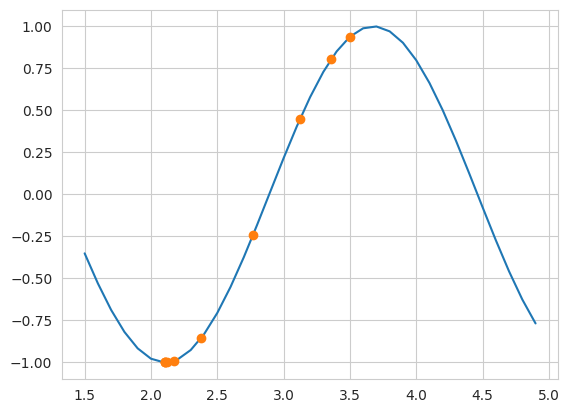

In [ ]:

x = [h['vars'][0] for h in history]
y = [h['loss'] for h in history]

x_fn = np.arange(1.5, 5, 0.1)
y_fn = [fn([x]).numpy().squeeze() for x in x_fn]

plt.plot(x_fn, y_fn, '-')
plt.plot(x, y, 'o')


### Regressão de Parábola

In [ ]:
NameManager.reset()

# optimize coefficients
a = Tensor(1)
b = Tensor(1)
c = Tensor(1)

class LossFn:
    def __init__(self):
        # generate dataset
        self.x = np.arange(-5, 5, 0.2)
        self.y = -0.5 * self.x ** 2 + 1 * self.x - 5

    def __call__(self, inputs):
        a, b, c = inputs

        total_loss = Tensor(0.0)

        for x_i, y_i in zip(self.x, self.y):
            prd = add(add(prod(a, x_i ** 2), prod(b, x_i)), c)
            loss = prod(square(sub(y_i, prd)), 1/len(self.x))
            total_loss = add(total_loss, loss)

        return total_loss

loss_fn = LossFn()
params = [a, b, c]
history = gd(loss_fn, 500, 7e-3, params)



[[468.11988]]
[[11.23744573]]
[[8.23565315]]
[[6.03611735]]
[[4.4240224]]
[[3.24247741]]
[[2.37649334]]
[[1.74179181]]
[[1.27660308]]
[[0.93565454]]
[[0.68576477]]
[[0.50261427]]
[[0.36837865]]
[[0.26999399]]
[[0.19788539]]
[[0.14503519]]
[[0.10629994]]
[[0.0779099]]
[[0.05710213]]
[[0.04185159]]


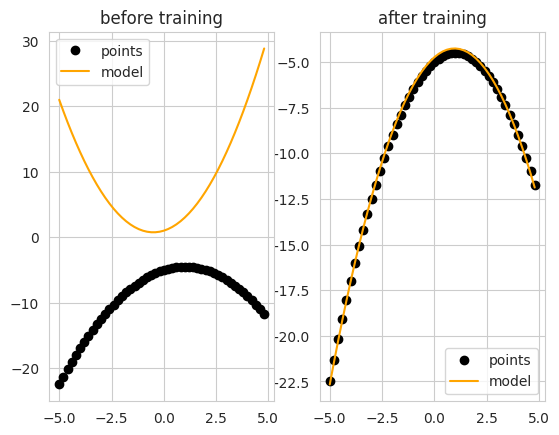

In [ ]:

plt.subplot(1, 2, 2)

a0, b0, c0 = history[0]['vars']

init_prd = a0 * loss_fn.x ** 2 + b0 * loss_fn.x + c0
final_prd = a.numpy().squeeze() * loss_fn.x ** 2 + b.numpy().squeeze() * loss_fn.x + c.numpy().squeeze()

plt.subplot(1, 2, 1)
plt.title('before training')
plt.plot(loss_fn.x, loss_fn.y, 'o', color='black', label='points')
plt.plot(loss_fn.x, init_prd, '-', color='orange', label='model')
plt.legend()
plt.subplot(1, 2, 2)
plt.title('after training')
plt.plot(loss_fn.x, loss_fn.y, 'o', color='black', label='points')
plt.plot(loss_fn.x, final_prd, '-', color='orange', label='model')
plt.legend()

plt.show()



### Regressão de Funções Periódicas

In [ ]:
NameManager.reset()

class SinRegLossFn:
    def __init__(self):
        self.x = np.arange(-3.0, 3.0, 0.2)
        self.y = np.sin(self.x * 5 + 1)

    def __call__(self, inputs):
        a, m = inputs

        total_loss = Tensor(0.0)

        for x_i, y_i in zip(self.x, self.y):
            prd = sin(add(prod(x_i, m), a))
            loss = prod(square(sub(y_i, prd)), 1/len(self.x))
            total_loss = add(total_loss, loss)

        return total_loss

# optimize coefficients
a = Tensor(5.2)
m = Tensor(5)

np.random.seed(1)
loss_fn = SinRegLossFn()
params = [a, m]
history = gd(loss_fn, 20, 2e-1, params)


[[1.46293346]]
[[1.28963745]]
[[1.09799693]]
[[0.90194422]]
[[0.7153339]]
[[0.5485333]]
[[0.40753614]]
[[0.29423467]]
[[0.20722436]]
[[0.14297783]]
[[0.09706196]]
[[0.06508453]]
[[0.04324698]]
[[0.028547]]
[[0.01875356]]
[[0.01227707]]
[[0.0080168]]
[[0.00522509]]
[[0.00340081]]
[[0.00221116]]


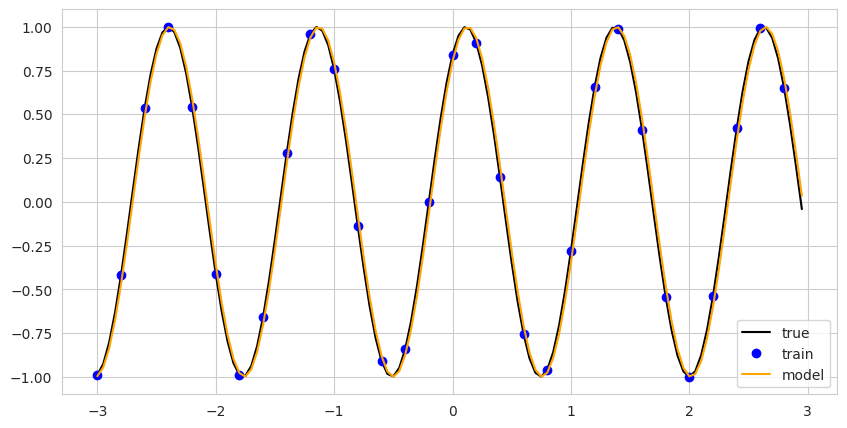

In [ ]:
# dados apenas para plotar com mais suavidade
all_x = np.arange(-3.0, 3.0, 0.05)
all_y = np.sin(all_x * 5 + 1)

a, m = history[-1]['vars']
prd_y = np.sin(all_x * m + a)

plt.close('all')
plt.figure(figsize=(10, 5))
plt.plot(all_x, all_y, '-', color='black', label='true')
plt.plot(loss_fn.x, loss_fn.y, 'o', color='blue', label='train')
plt.plot(all_x, prd_y, '-', color='orange', label='model')
plt.legend()
plt.show()

## Regressão com Redes Neurais

Fazemos um treino com cada tipo de função de ativação.

In [ ]:

NameManager.reset()


def init(nrows, ncols):
    return 0.1 * np.random.normal(size=(nrows, ncols))

class Mlp:
    def __init__(self, act_fn):
        self._act_fn = act_fn

        self._w0 = Tensor(init(64, 1), name='weights')
        self._b0 = Tensor(init(64, 1), name='bias')

        self._w1 = Tensor(init(64, 64), name='weights')
        self._b1 = Tensor(init(64, 1), name='bias')

        self._w2 = Tensor(init(1, 64), name='weights')
        self._b2 = Tensor(init(1, 1), name='bias')

    def forward(self, x):
        z0 = add(matmul(self._w0, x), self._b0)
        h0 = self._act_fn(z0)

        z1 = add(matmul(self._w1, h0), self._b1)
        h1 = self._act_fn(z1)

        y = add(matmul(self._w2, h1), self._b2)

        return y

    def parameters(self):
        return [self._w0, self._b0, self._w1, self._b1]


class NeuralSinRegLossFn:
    def __init__(self, mlp):
        self.x = np.arange(-3.0, 3.0, 0.2)
        self.y = np.sin(self.x)
        self.y += np.random.normal(size=self.y.shape) * 0.2
        self.mlp = mlp

    def __call__(self, inputs):
        # vamos usar a mlp diretamente dado que seus
        # parametros sao armazenados por referencia

        total_loss = Tensor(0.0)

        for x_i, y_i in zip(self.x, self.y):
            prd = self.mlp.forward(x_i)
            loss = prod(square(sub(y_i, prd)), 1/len(self.x))
            total_loss = add(total_loss, loss)

        return total_loss

np.random.seed(1)
mlp = Mlp(relu)
loss_fn = NeuralSinRegLossFn(mlp)
params = mlp.parameters()
history = gd(loss_fn, 3000, 1e-1, params)

[[0.60539212]]
[[0.0852884]]
[[0.05724559]]
[[0.04534972]]
[[0.04023955]]
[[0.03703433]]
[[0.03409913]]
[[0.03161883]]
[[0.02931419]]
[[0.02811975]]
[[0.02716084]]
[[0.02635995]]
[[0.02567843]]
[[0.02507809]]
[[0.02453386]]
[[0.02403302]]
[[0.02356425]]
[[0.0231234]]
[[0.02274007]]
[[0.02235428]]


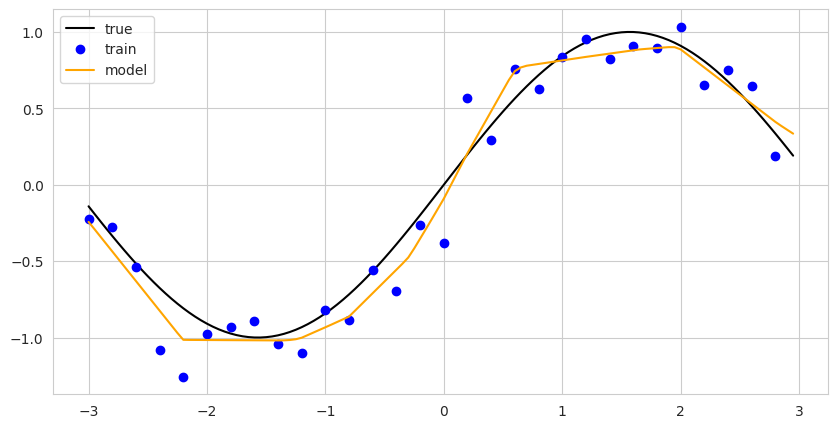

In [ ]:
# dados apenas para plotar com mais suavidade
all_x = np.arange(-3.0, 3.0, 0.05)
all_y = np.sin(all_x)

prd_y = [mlp.forward(x_i).numpy().squeeze() for x_i in all_x]

plt.close('all')
plt.figure(figsize=(10, 5))
plt.plot(all_x, all_y, '-', color='black', label='true')
plt.plot(loss_fn.x, loss_fn.y, 'o', color='blue', label='train')
plt.plot(all_x, prd_y, '-', color='orange', label='model')
plt.legend()
plt.show()

Usando a `tanh` como função de ativação.

In [ ]:

np.random.seed(1)
mlp = Mlp(tanh)
loss_fn = NeuralSinRegLossFn(mlp)
params = mlp.parameters()
history = gd(loss_fn, 3000, 1e-1, params)

[[0.64213178]]
[[0.06429985]]
[[0.03874641]]
[[0.03652965]]
[[0.03516874]]
[[0.03413861]]
[[0.03334055]]
[[0.03271227]]
[[0.03221036]]
[[0.03180353]]
[[0.03146891]]
[[0.0311897]]
[[0.03095348]]
[[0.03075098]]
[[0.03057529]]
[[0.03042116]]
[[0.03028458]]
[[0.03016247]]
[[0.03005242]]
[[0.02995254]]


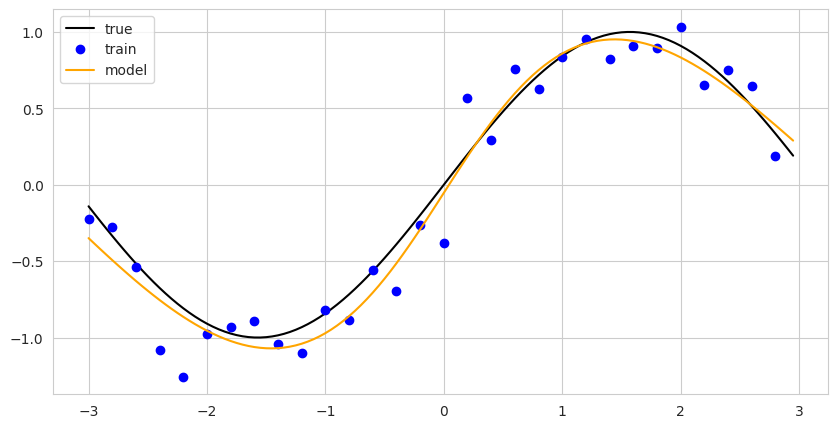

In [ ]:
# dados apenas para plotar com mais suavidade
all_x = np.arange(-3.0, 3.0, 0.05)
all_y = np.sin(all_x)

prd_y = [mlp.forward(x_i).numpy().squeeze() for x_i in all_x]

plt.close('all')
plt.figure(figsize=(10, 5))
plt.plot(all_x, all_y, '-', color='black', label='true')
plt.plot(loss_fn.x, loss_fn.y, 'o', color='blue', label='train')
plt.plot(all_x, prd_y, '-', color='orange', label='model')
plt.legend()
plt.show()

Usando a sigmoide.

In [ ]:

np.random.seed(1)
mlp = Mlp(sigmoid)
loss_fn = NeuralSinRegLossFn(mlp)
params = mlp.parameters()
history = gd(loss_fn, 3000, 7e-1, params)

[[0.61286181]]
[[0.13933899]]
[[0.0890533]]
[[0.06184236]]
[[0.0515937]]
[[0.04756851]]
[[0.04563713]]
[[0.04439965]]
[[0.04341436]]
[[0.04254533]]
[[0.04174883]]
[[0.0410142]]
[[0.04034116]]
[[0.03972749]]
[[0.03916814]]
[[0.03865725]]
[[0.03818912]]
[[0.03775854]]
[[0.03736089]]
[[0.0369924]]


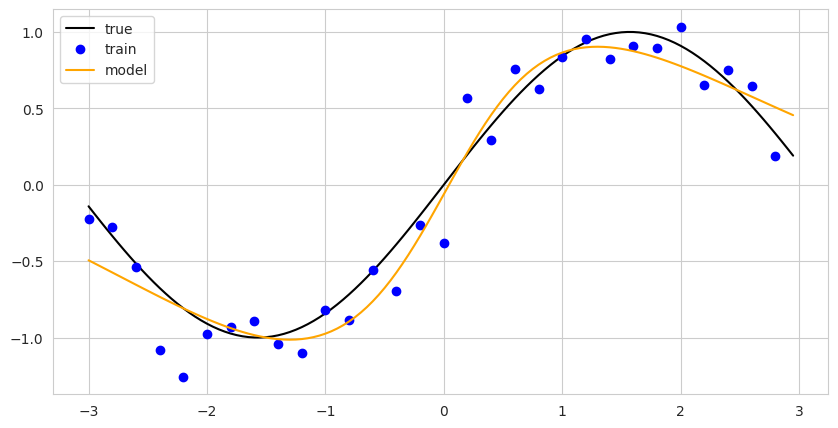

In [ ]:
# dados apenas para plotar com mais suavidade
all_x = np.arange(-3.0, 3.0, 0.05)
all_y = np.sin(all_x)

prd_y = [mlp.forward(x_i).numpy().squeeze() for x_i in all_x]

plt.close('all')
plt.figure(figsize=(10, 5))
plt.plot(all_x, all_y, '-', color='black', label='true')
plt.plot(loss_fn.x, loss_fn.y, 'o', color='blue', label='train')
plt.plot(all_x, prd_y, '-', color='orange', label='model')
plt.legend()
plt.show()

In [ ]:
import pickle

with open("data.pkl", "wb") as f:
    pickle.dump(results, f)

NameError: name 'results' is not defined